In [1]:
import os

import tensorflow as tf
import matplotlib.pyplot as plt

2025-01-16 13:13:33.238488: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-16 13:13:33.239835: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 13:13:33.269286: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-16 13:13:33.269603: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-16 13:13:35.899629: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

KeyboardInterrupt: 

In [ ]:
root_dir = '/l/data/molnet/water-bilayer-tf/'

fnames = [
    os.path.join(root_dir, f)
    for f in os.listdir(root_dir)
    if f.startswith('afms_')
]
print(f"loaded {len(fnames)} files")

loaded 11 files


In [ ]:
def get_dataset(fnames):
    element_spec = tf.data.Dataset.load(fnames[0]).element_spec

    # Load the files.
    ds = tf.data.Dataset.from_tensor_slices(fnames)
    # Shuffle the files.
    ds = ds.shuffle(1000)
    ds = ds.interleave(
        lambda path: tf.data.Dataset.load(path, element_spec=element_spec),
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    ds = ds.map(
        lambda x: {
            "images": x["x"],
            "xyz": x["xyz"],
            "sw": x["sw"],
        },
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    ds = ds.map(
        preprocess_images,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    ds = ds.map(
        compute_atom_map,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    ds = ds.map(
        pad_xyz,
        num_parallel_calls=tf.data.AUTOTUNE,
        deterministic=True,
    )

    ds = ds.batch(4)
    ds = ds.prefetch(tf.data.AUTOTUNE).as_numpy_iterator()

    return ds


def compute_atom_map(batch):
    xyz = batch["xyz"]
    z_max = tf.reduce_max(xyz[:, 2])
    sw = batch["sw"]

    x = tf.linspace(sw[0, 0], sw[1, 0], 256)
    y = tf.linspace(sw[0, 1], sw[1, 1], 256)
    z = tf.linspace(z_max, z_max-2.0, 20)

    X, Y, Z = tf.meshgrid(x, y, z, indexing='xy')

    map_o = tf.zeros_like(X)
    map_h = tf.zeros_like(X)

    for atom in xyz:

        if atom[2] < z_max - 2.5:
            continue

        m = tf.exp(
            -((X - atom[0])**2 + (Y - atom[1])**2 + (Z - atom[2])**2) / (2.0 * 0.3**2)
        )
        m = tf.where(m < 0.01, 0.0, m*5)

        if atom[-1] == 1:
            map_h += m
        elif atom[-1] == 8:
            map_o += m
        #else:
        #    raise ValueError(f"Unknown atom type {atom[-1]}")
        
    atom_map = tf.stack([map_o, map_h], axis=-1)
        
    return {
        "images": batch["images"],
        "xyz": batch["xyz"],
        "sw": batch["sw"],
        "atom_map": atom_map,
    }

def preprocess_images(batch):
    x = batch["images"]
    x = tf.transpose(x, perm=[1, 0, 2])

    # Reverse the x-axis.
    x = x[::-1, :, :]

    return {
        "images": x,
        "xyz": batch["xyz"],
        "sw": batch["sw"],
    }


def pad_xyz(batch):
    xyz = batch["xyz"]
    n_atoms = tf.shape(xyz)[0]
    pad = 500 - n_atoms
    xyz = tf.pad(xyz, [[0, pad], [0, 0]])
    return {
        "images": batch["images"],
        "xyz": xyz,
        "sw": batch["sw"],
        "atom_map": batch["atom_map"],
    }


In [ ]:
ds = get_dataset(fnames)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 9542058055893189865


In [78]:
batch = next(ds)

[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 8610686302854659539
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:1: Invalid control characters encountered in text.
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing text-format tensorflow.data.experimental.DistributedSnapshotMetadata: 1:3: Expected identifier, got: 12320820874903670224
[libprotobuf ERROR external/com_google_protobuf/src/google/protobuf/text_format.cc:337] Error parsing t

In [79]:
for k, v in batch.items():
    print(k, v.shape)

images (4, 256, 256, 15)
xyz (4, 500, 5)
sw (4, 2, 3)
atom_map (4, 256, 256, 20, 2)


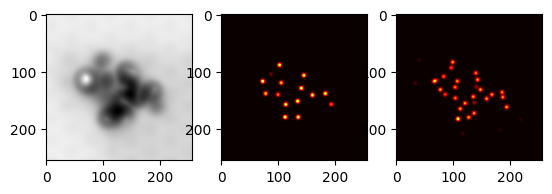

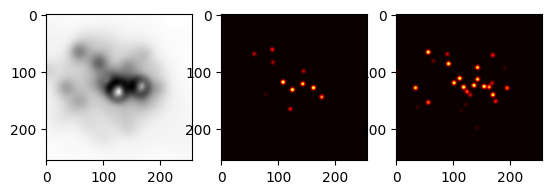

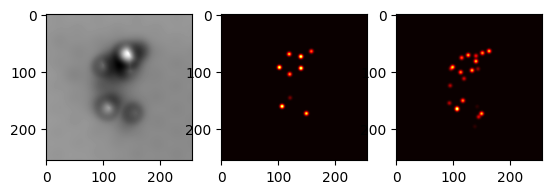

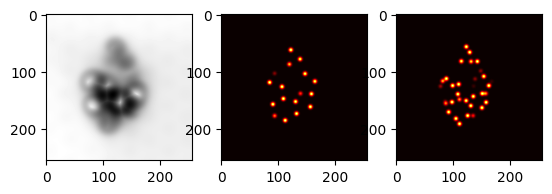

In [80]:
x = batch["images"]
y = batch["atom_map"]

for i in range(x.shape[0]):
    ax = plt.subplot(131)
    ax.imshow(x[i].mean(axis=-1), cmap='gray')

    ax = plt.subplot(132)
    ax.imshow(y[i, ..., 0].mean(axis=-1), cmap='hot')

    ax = plt.subplot(133)
    ax.imshow(y[i, ..., 1].mean(axis=-1), cmap='hot')

    plt.show()